In [1]:
#Importing sparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

#Importing graphical libraries for plots
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Creating the SparkSession
spark = SparkSession.builder.appName("NYC Parking Ticket Analysis").getOrCreate()

In [3]:
#Checking if sparkSession got created
spark

As we see, the spark session is has been created successfully with the required application name.

In [4]:
# Reading data from the CSV file
data = spark.read.format('csv').option("header","true").load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv").cache()

In [5]:
#Let's check if the data read was correct. The header must be skipped
data.show(2)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
only showing top 2 rows



In [6]:
# The total number of rows in the given dataset
data.count()

10803028

In [7]:
# Let's check the minimum & maximum issue_date in the given dataset
data.agg(min('Issue Date').alias("min_issue_date"), max('Issue Date').alias("max_issue_date")).show()

+--------------+--------------+
|min_issue_date|max_issue_date|
+--------------+--------------+
|    1972-03-30|    2069-11-19|
+--------------+--------------+



#### As we see above, there are a lot of unnecessary rows. Let's filter the data for the year 2017.

In [8]:
# Let's filter the rows for the year 2017
data = data.filter(year(col('Issue Date')) == 2017)

In [9]:
#Let's check a few rows of the data
data.show(2)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
only showing top 2 rows



#### It seems that the data has been filtered successfully

In [10]:
# Let's check the dataframe again with filter, this should return us 0 rows
data.filter(year(col('Issue Date')) != 2017).count()

0

##### As we get the count of rows which do not belong to the year 2017 to be 0. Therefore, the data has been successfully filtered for the year 2017

## Examine the data


### Find the total number of tickets for the year.


In [11]:
data.count()

5431918

### Find out the number of unique states from where the cars that got parking tickets came

In [12]:
data.select(col('Registration State')).distinct().count()

65

Therefore, the cars which got the tickets belong to 65 unique registration states

### Let's see the unique registration states

In [13]:
data.select(col('Registration State')).distinct().show(100)

+------------------+
|Registration State|
+------------------+
|                SC|
|                AZ|
|                NS|
|                LA|
|                MN|
|                NJ|
|                DC|
|                OR|
|                99|
|                VA|
|                RI|
|                KY|
|                WY|
|                BC|
|                NH|
|                MI|
|                NV|
|                GV|
|                QB|
|                WI|
|                ID|
|                CA|
|                CT|
|                NE|
|                MT|
|                NC|
|                VT|
|                MD|
|                DE|
|                MO|
|                IL|
|                ME|
|                MB|
|                WA|
|                ND|
|                MS|
|                AL|
|                IN|
|                OH|
|                TN|
|                IA|
|                NM|
|                PA|
|                SD|
|            

As given in the assignment details, there is one incorrect state i.e. 99. Let's replace it with the state that occurs the most

### Finding the state that occurs the most

In [14]:
data.groupby("Registration State").count().sort('count',ascending = False).show(4)

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|4273951|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
+------------------+-------+
only showing top 4 rows



As we see above, NY is the most occuring registration state.

### Let's replace incorrect registration state '99' by 'NY'

In [15]:
# Let's first check the number of records with '99' as the registration state
data.filter(col("Registration State") == '99').count()

16055

In [16]:
# Let's check the number of records with 'NY' as the registration state
data.filter(col("Registration State") == 'NY').count()

4273951

In [17]:
# Let's replace the incorrect registration state '99' by 'NY'
data = data.withColumn("Registration State",when(col("Registration State") == '99',"NY").otherwise(col("Registration State")))

In [18]:
# Check1 for the replacement i.e. the count where '99' is the value must be 0
data.filter(col("Registration State") == '99').count()

0

In [19]:
#Let's again check the number of records with 'NY' as the registration state, it must be increased by the count of rows where '99' was the value
data.filter(col("Registration State") == 'NY').count()

4290006

In [20]:
#Let's check the total comes out equal or not
4290006 ==  4273951 + 16055

True

Therefore, the value '99' in the column 'Registration State' has been successfully replaced

### Let's find out the number of unique states again

In [21]:
data.select('Registration State').distinct().count()

64

#### Therefore, the number of unique states now comes out to be 64

## Aggregation Tasks

### Finding the frequency of the top five violation codes.

In [22]:
violationCodeData = data.groupBy('Violation code').count().sort('count', ascending = False)
violationCodeData.show(5)

+--------------+------+
|Violation code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
|            14|476664|
|            20|319646|
+--------------+------+
only showing top 5 rows



#### Therefore, the top 5 violation codes in the descending order of the count of issued tickets are 21, 36, 38, 14, 20

In [23]:
#Total number of Voilation codes
violationCodeData.count()

100

In [24]:
# Let's define a function to draw bar plots
def barPlotOnColumns(x,y,data,order,size):
    plt.figure(figsize = size)
    sns.barplot(x = x, y = y, data = data, order=data[order])
    plt.show()

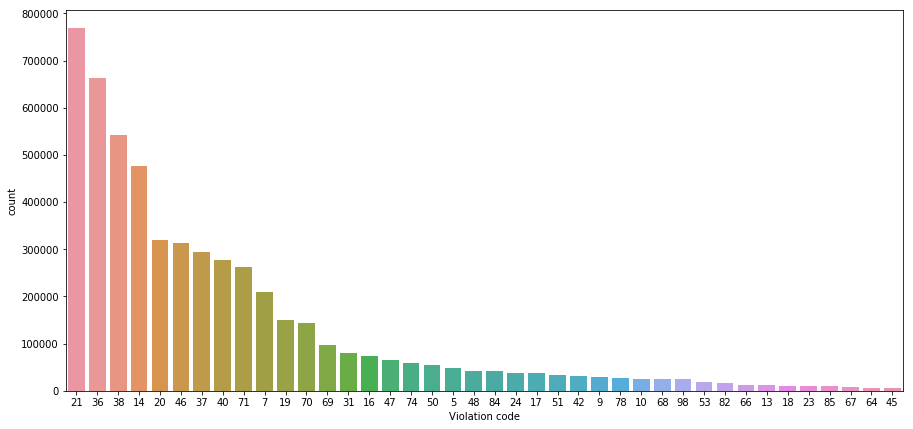

In [25]:
#Plotting the frequency of the violation codes (Top 10 violation codes)
barPlotOnColumns('Violation code', 'count', violationCodeData.toPandas().head(40), 'Violation code', (15,7))

### Finding top 5 'vehicle body type' which get the highest parking tickets

In [26]:
vehicleBodyTypeDf = data.groupBy("Vehicle Body Type").count().sort('count', ascending = False)
vehicleBodyTypeDf.show(5)

+-----------------+-------+
|Vehicle Body Type|  count|
+-----------------+-------+
|             SUBN|1883954|
|             4DSD|1547312|
|              VAN| 724029|
|             DELV| 358984|
|              SDN| 194197|
+-----------------+-------+
only showing top 5 rows



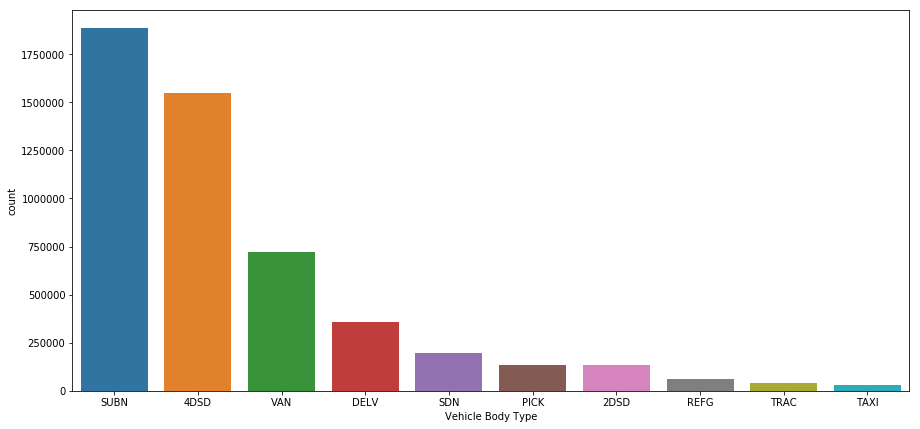

In [27]:
#Plotting the frequency of the Vehicle Body Types (Top 5 vehicle body types)
barPlotOnColumns('Vehicle Body Type', 'count', vehicleBodyTypeDf.toPandas().head(10), 'Vehicle Body Type', (15,7))

### Finding top 5 'vehicle make' which get the highest parking tickets

In [28]:
# Let's check the number of Vehicle make in our dataset
data.select("Vehicle Make").distinct().count()

3179

In [29]:
# Finding out the number of issued tickets against each of the 'Vehicle make'
vehicleMakeDf = data.groupBy('Vehicle Make').count().sort('count', ascending = False)
vehicleMakeDf.show(10)

+------------+------+
|Vehicle Make| count|
+------------+------+
|        FORD|636844|
|       TOYOT|605291|
|       HONDA|538884|
|       NISSA|462017|
|       CHEVR|356032|
|       FRUEH|230787|
|       ME/BE|197568|
|       DODGE|187729|
|         BMW|186700|
|        JEEP|175815|
+------------+------+
only showing top 10 rows



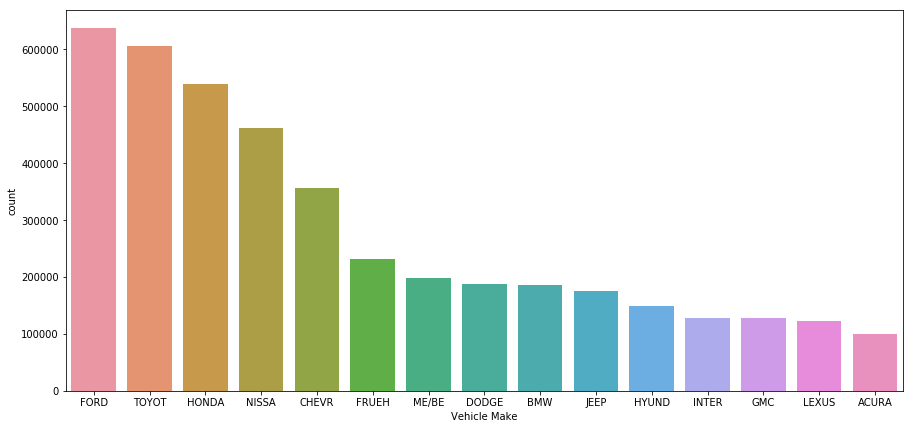

In [30]:
# Plotting the top 15 Vehicle makes with highest ticket count in descending order
barPlotOnColumns('Vehicle Make', 'count', vehicleMakeDf.toPandas().head(15), 'Vehicle Make', (15,7))

### Finding top 'Violation Precinct(s)' 

In [31]:
violationPrecinctDf = data.groupBy('Violation Precinct').count().sort('count', ascending = False)
violationPrecinctDf.show(10)

+------------------+------+
|Violation Precinct| count|
+------------------+------+
|                 0|925596|
|                19|274445|
|                14|203553|
|                 1|174702|
|                18|169131|
|               114|147444|
|                13|125113|
|               109|104008|
|                17|103255|
|                70| 96552|
+------------------+------+
only showing top 10 rows



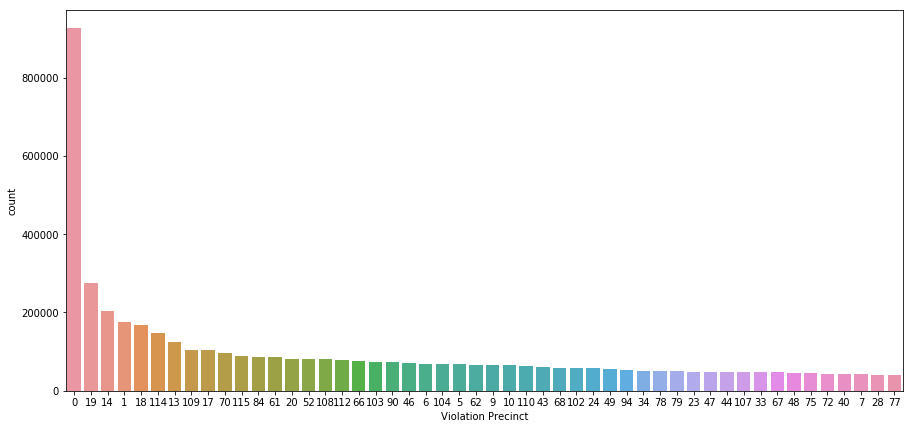

In [32]:
# Plotting graph on 'Violation Precinct' vs 'Number of issued tickets'
barPlotOnColumns('Violation Precinct','count',violationPrecinctDf.toPandas().head(50),'Violation Precinct', (15,7))

### Finding top Issuer Precincts

In [33]:
issuerPrecinctDf = data.groupBy('Issuer Precinct').count().sort('count', ascending = False)
issuerPrecinctDf.show(10)

+---------------+-------+
|Issuer Precinct|  count|
+---------------+-------+
|              0|1078406|
|             19| 266961|
|             14| 200495|
|              1| 168740|
|             18| 162994|
|            114| 144054|
|             13| 122490|
|            109| 105109|
|             17| 100641|
|             70|  92298|
+---------------+-------+
only showing top 10 rows



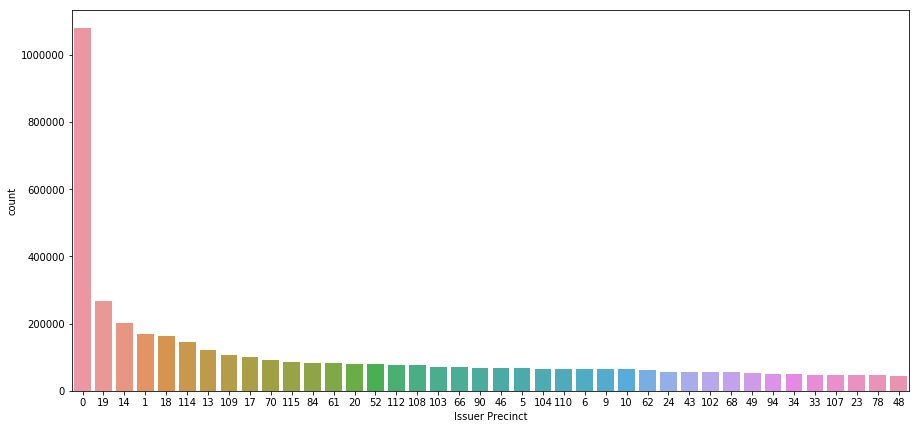

In [34]:
# Plotting the 'Issuer Precint' vs 'Count of tickets agains each Precinct'
barPlotOnColumns('Issuer Precinct', 'count', issuerPrecinctDf.toPandas().head(40), 'Issuer Precinct', (15,7))

#### It seems that 0 are the erroneous rows, let's find the top 5 violation precincts & top 5 issuer precincts again by removing the rows with 0 as the precinct

### Finding top 5 Violation precincts by removing precinct 0

In [35]:
violationPrecinctDf = data.filter(col("Violation Precinct") != "0" ).groupBy('Violation Precinct').count().sort('count', ascending = False)
violationPrecinctDf.show(5)

+------------------+------+
|Violation Precinct| count|
+------------------+------+
|                19|274445|
|                14|203553|
|                 1|174702|
|                18|169131|
|               114|147444|
+------------------+------+
only showing top 5 rows



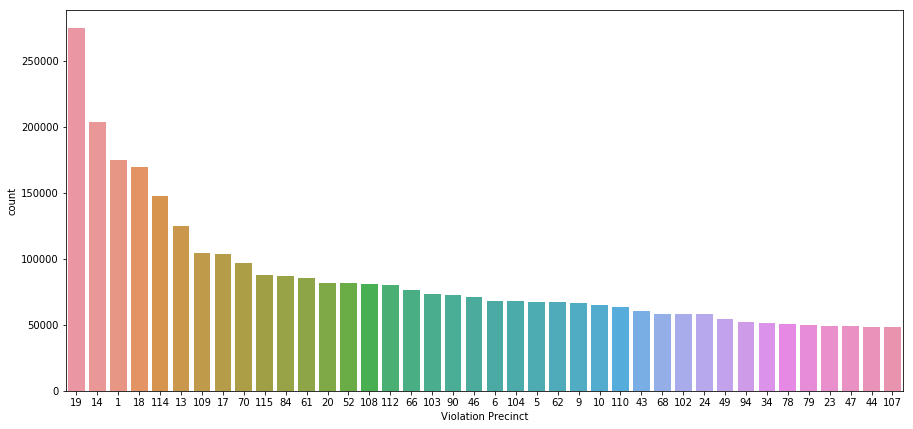

In [36]:
# Plotting the 'Violation Precint' vs 'Count of tickets agains each Precinct'
barPlotOnColumns('Violation Precinct','count',violationPrecinctDf.toPandas().head(40),'Violation Precinct', (15,7))

#### As seen above, the highest number of parking violations occur in Precinct 19 with 70000 more tickets than the precinct with second highest number of tickets. Rest of the ranking can be seen in the decreasing order as 19, 14, 1, 18, 114.

### Finding top 5 Issuer precincts by remvoing precinct 0

In [37]:
issuerPrecinctDf = data.filter(col("Issuer Precinct") != 0).groupBy('Issuer Precinct').count().sort('count', ascending = False)
issuerPrecinctDf.show(5)

+---------------+------+
|Issuer Precinct| count|
+---------------+------+
|             19|266961|
|             14|200495|
|              1|168740|
|             18|162994|
|            114|144054|
+---------------+------+
only showing top 5 rows



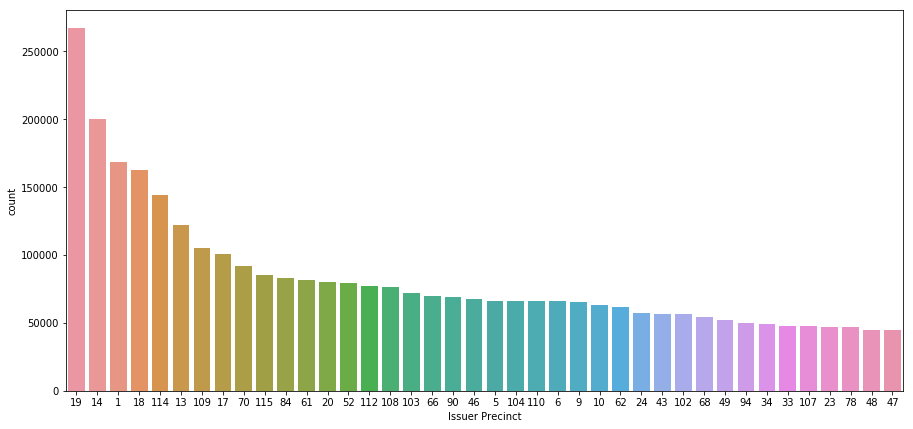

In [38]:
# Plotting the 'Issuer Precint' vs 'Count of tickets agains each Precinct'
barPlotOnColumns('Issuer Precinct', 'count', issuerPrecinctDf.toPandas().head(40), 'Issuer Precinct', (15,7))

#### The highest number of tickets belong to Issuer Precinct 19 with 66000 more tickets than the precinct with second highest number of tickets. Top 5 in the descending order are 19, 14, 1, 18, 114

#### From the above graphs, we see that the Top 14 precincts i.e .Issuer/ Violation are having high number of tickets in the same order

### Finding the violation code frequency for each of the 3 Precincts which have highest number of violations tickets

In [39]:
# Violation codes & frequency of tickets issued against each violation code for precinct 19
violationCodePrecinct19 = data.filter((col("Violation Precinct") == '19')).groupBy('Violation Code').count().sort('count', ascending = False)
violationCodePrecinct19.show(5)

+--------------+-----+
|Violation Code|count|
+--------------+-----+
|            46|50785|
|            38|37483|
|            37|36468|
|            14|30376|
|            21|29415|
+--------------+-----+
only showing top 5 rows



<b>The Violation Code 46 is having highest number of count of tickets i.e. approximately 13,000 higher than the violation code with second highest number of tickets.

In [40]:
# Violation codes & frequency of tickets issued against each violation code for precinct 14
violationCodePrecinct14 = data.filter(col("Violation Precinct") == '14').groupBy('Violation Code').count().sort('count', ascending = False)
violationCodePrecinct14.show(5)

+--------------+-----+
|Violation Code|count|
+--------------+-----+
|            14|45885|
|            69|30465|
|            31|22649|
|            47|18691|
|            42|10027|
+--------------+-----+
only showing top 5 rows



<b> The Violation Code 14 is having highest number of count of tickets i.e. approximately 15,000 higher than the violation code with second highest number of tickets.

In [41]:
# Violation codes & frequency of tickets issued against each violation code for precinct 1
violationCodePrecinct1 = data.filter(col("Violation Precinct") == '1').groupBy('Violation Code').count().sort('count', ascending = False)
violationCodePrecinct1.show(5)

+--------------+-----+
|Violation Code|count|
+--------------+-----+
|            14|40226|
|            16|19278|
|            20|15743|
|            46|13534|
|            38| 8588|
+--------------+-----+
only showing top 5 rows



<b> The Violation Code 14 is having highest number of count of tickets i.e. approximately 21,000 higher than the violation code with second highest number of tickets.

<b> The Violation code 14 is common if we consider the top 5 violation code among the top 3 precincts

### Let's do some analysis on the timeframe. But before that we need to convert the time into the require format

In [42]:
data.show(2)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
only showing top 2 rows



In [43]:
# Let's convert the violation time in the required format as HH:mm
data = data.withColumn("Violation Time", when(col("Violation Time").startswith("00"), concat(lit("12"),substring("Violation Time",3,3))).otherwise(col("Violation Time")))\
.withColumn("Violation Time (AM/PM)",concat(col("Violation Time"), lit("M")))\
.withColumn('violation_timestamp', to_timestamp('Violation Time (AM/PM)','hhmma'))\
.withColumn("violation_time_rectified",date_format(col('violation_timestamp'), format='HH:mm')).cache()

data.select('Violation Time', 'Violation Time (AM/PM)', 'violation_timestamp', 'violation_time_rectified').show(20)

+--------------+----------------------+-------------------+------------------------+
|Violation Time|Violation Time (AM/PM)|violation_timestamp|violation_time_rectified|
+--------------+----------------------+-------------------+------------------------+
|         1120A|                1120AM|1970-01-01 11:20:00|                   11:20|
|         0852P|                0852PM|1970-01-01 20:52:00|                   20:52|
|         1215A|                1215AM|1970-01-01 00:15:00|                   00:15|
|         0525A|                0525AM|1970-01-01 05:25:00|                   05:25|
|         0256P|                0256PM|1970-01-01 14:56:00|                   14:56|
|         1232A|                1232AM|1970-01-01 00:32:00|                   00:32|
|         1034A|                1034AM|1970-01-01 10:34:00|                   10:34|
|         1021A|                1021AM|1970-01-01 10:21:00|                   10:21|
|         0721A|                0721AM|1970-01-01 07:21:00|      

In [45]:
#Let's create another column i.e. violation_hour
data = data.withColumn('violation_hour',hour("violation_time_rectified"))
data.select("violation_time_rectified", "violation_hour").show(10)

+------------------------+--------------+
|violation_time_rectified|violation_hour|
+------------------------+--------------+
|                   11:20|            11|
|                   20:52|            20|
|                   00:15|             0|
|                   05:25|             5|
|                   14:56|            14|
|                   00:32|             0|
|                   10:34|            10|
|                   10:21|            10|
|                   07:21|             7|
|                   09:40|             9|
+------------------------+--------------+
only showing top 10 rows



In [46]:
# Let's check the unique values in 'violation_hour'
data.select('violation_hour').distinct().show(30)

+--------------+
|violation_hour|
+--------------+
|            12|
|            22|
|          null|
|             1|
|            13|
|            16|
|             6|
|             3|
|            20|
|             5|
|            19|
|            15|
|             9|
|            17|
|             4|
|             8|
|            23|
|             7|
|            10|
|            21|
|            11|
|            14|
|             2|
|             0|
|            18|
+--------------+



As we see above, there are null values as well in the generated column 'violation_hour'

In [47]:
#Let's count the number of null values in the column 'violation_time_rectified'
data.filter(isnull("violation_time_rectified")).count()

108

In [49]:
#Let's check the reason for getting null values in the 'violation_time_recitified' column
data.filter(isnull("violation_time_rectified")).select("Violation time","Violation Time (AM/PM)","violation_timestamp","violation_time_rectified","violation_hour").show()

+--------------+----------------------+-------------------+------------------------+--------------+
|Violation time|Violation Time (AM/PM)|violation_timestamp|violation_time_rectified|violation_hour|
+--------------+----------------------+-------------------+------------------------+--------------+
|           nan|                  nanM|               null|                    null|          null|
|         6815P|                6815PM|               null|                    null|          null|
|          0557|                 0557M|               null|                    null|          null|
|         110+A|                110+AM|               null|                    null|          null|
|           nan|                  nanM|               null|                    null|          null|
|         093+A|                093+AM|               null|                    null|          null|
|         8715P|                8715PM|               null|                    null|          null|


#### As we see above, there are incorrect values in the provided 'Violation time' column. Let's remove the null values from the dataframe

In [50]:
# Let's get the total number of rows in the dataset
data.count()

5431918

In [51]:
#Removing null values from column 'Violation time'
data = data.filter(~isnull("violation_time_rectified"))

In [52]:
data.count()

5431810

##### Therefore, now we have removed the 108 rows with incorrect 'violation time'

#### Therefore, now we have the correct hours across the days, let's analyze parking violations based upon hours

In [53]:
#Getting count of tickets corresponding to each hour
violationHourlyData = data.groupBy('violation_hour').count().sort('count',ascending = False)
violationHourlyData.show(30)

+--------------+------+
|violation_hour| count|
+--------------+------+
|             9|595625|
|            11|574630|
|            13|549287|
|            12|510134|
|             8|503843|
|            10|489456|
|            14|466068|
|            15|314468|
|            16|295983|
|             7|270626|
|            17|211173|
|             6|121550|
|            18|104283|
|            21| 55321|
|            20| 49221|
|             1| 46068|
|             0| 45698|
|             5| 43154|
|            22| 42536|
|             2| 40312|
|             3| 32453|
|            23| 29277|
|            19| 26099|
|             4| 14545|
+--------------+------+



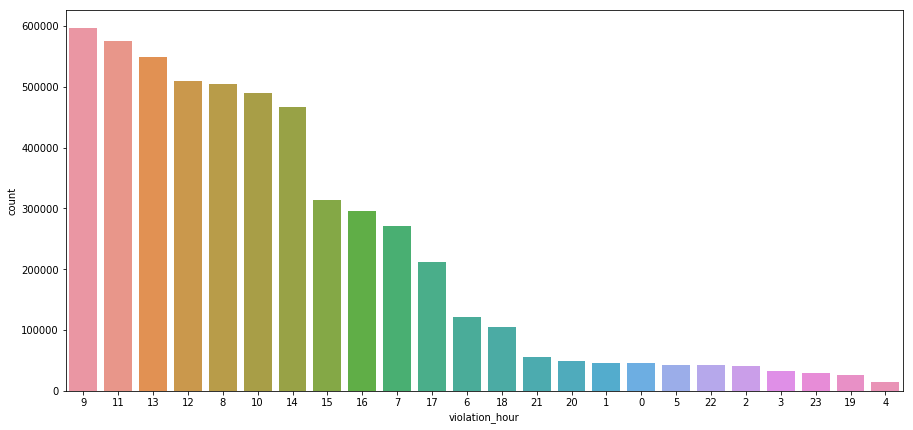

In [54]:
# Plot of count of tickets vs violation_hour
barPlotOnColumns('violation_hour','count',violationHourlyData.toPandas(),'violation_hour',(15,7))

#### As we observe from the above graph, that the top violation hours are from 8:00 AM to 2:00PM with the count of tickets being highest at 9:00AM

### Let's create categories out of the violation hours

<b> Hours will be created based on the logic that:
- Afternoon -> 13 to 16
- Evening -> 17 to 20
- Night -> 21 to 24 (0 here)
- Late Night -> 1 to 4
- Early Morning -> 5 to 8
- Morning -> 9 to 12
Where all the hours i.e. 13, 16, 21, 24, etc. are in 24 hour time format

In [55]:
def categoriseHoursIntoCategories(hour):
    if((hour>12) & (hour<=16)):
        return "Afternoon"
    elif((hour>16) & (hour<=20)):
        return "Evening"
    elif((hour>20) & (hour<=23) | (hour==0)):
        return "Night"
    elif((hour>0) & (hour<=4)):
        return "Late Night"
    elif((hour>4) & (hour<=8)):
        return "Early Morning"
    elif((hour>8) & (hour<=12)):
        return "Morning"

categoriseHourUdf = udf(categoriseHoursIntoCategories, StringType())

In [56]:
#Testing if the function is categorizing correctly
for i in range(0,24):
    print(categoriseHoursIntoCategories(i))

Night
Late Night
Late Night
Late Night
Late Night
Early Morning
Early Morning
Early Morning
Early Morning
Morning
Morning
Morning
Morning
Afternoon
Afternoon
Afternoon
Afternoon
Evening
Evening
Evening
Evening
Night
Night
Night


In [57]:
# Creating the column violation_hour_category using the UDF we created earlier
data = data.withColumn("violation_hour_category",categoriseHourUdf(col("violation_hour")))
data.cache()
data.select("violation_hour", "violation_hour_category").show(10)

+--------------+-----------------------+
|violation_hour|violation_hour_category|
+--------------+-----------------------+
|            11|                Morning|
|            20|                Evening|
|             0|                  Night|
|             5|          Early Morning|
|            14|              Afternoon|
|             0|                  Night|
|            10|                Morning|
|            10|                Morning|
|             7|          Early Morning|
|             9|                Morning|
+--------------+-----------------------+
only showing top 10 rows



In [58]:
# Let's analyze the tickets corresponding to 'violatin_hour_category'
violationHourCategoryDf = data.select("violation_hour_category").groupBy('violation_hour_category').count().sort('count', ascending = False)
violationHourCategoryDf.show()

+-----------------------+-------+
|violation_hour_category|  count|
+-----------------------+-------+
|                Morning|2169845|
|              Afternoon|1625806|
|          Early Morning| 939173|
|                Evening| 390776|
|                  Night| 172832|
|             Late Night| 133378|
+-----------------------+-------+



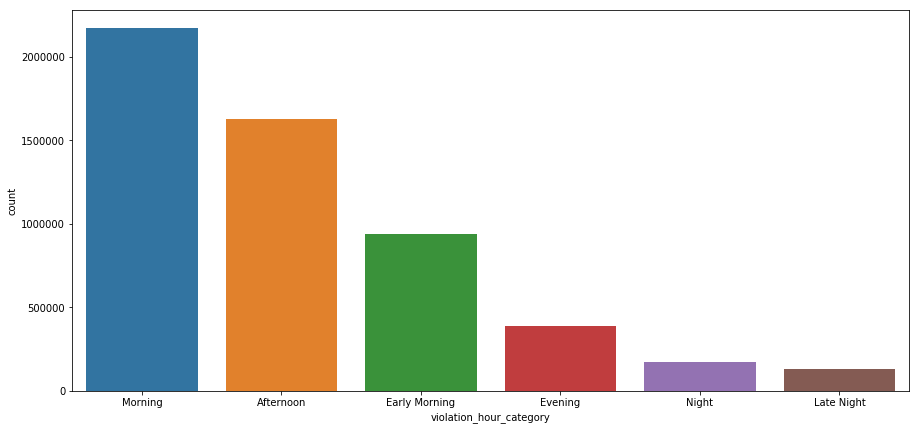

In [59]:
#Let's create a plot for the count of tickets vs violation_hour_category
barPlotOnColumns('violation_hour_category', 'count', violationHourCategoryDf.toPandas(), 'violation_hour_category', (15,7))

##### As seen in the above graph, the highest number of tickets are issued in the morning then afternoon then early morning.<br> <br> The least number of tickets are issued during evening, night & late night categories

### Let's find the three most commonly occuring violations for each of the hour based categories

In [60]:
mostCommonOccuringViolations = data.groupBy('violation_hour_category', 'Violation Code').count()
mostCommonOccuringViolations.show()

+-----------------------+--------------+-----+
|violation_hour_category|Violation Code|count|
+-----------------------+--------------+-----+
|             Late Night|            78|13321|
|              Afternoon|            70|53300|
|              Afternoon|            82| 5908|
|             Late Night|            51| 1806|
|              Afternoon|             0|   68|
|              Afternoon|            50|13999|
|              Afternoon|            69|31034|
|              Afternoon|            19|47179|
|                Evening|            12|   16|
|                Evening|            84|  951|
|          Early Morning|            79|  316|
|                Evening|            35|   74|
|              Afternoon|            94|   37|
|          Early Morning|            72| 1025|
|                Evening|            30|   97|
|              Afternoon|            87|    1|
|          Early Morning|            95|    7|
|                Evening|            77|  474|
|            

In [61]:
# Filtering data for top 3 violation codes among each of the 'violation hour category'
w = Window.partitionBy('violation_hour_category').orderBy(col("count").desc())
top3AmongEachCategory = mostCommonOccuringViolations.withColumn('rank',dense_rank().over(w)).filter(col('rank')<4)
top3AmongEachCategory.cache()
top3AmongEachCategory.show()

+-----------------------+--------------+------+----+
|violation_hour_category|Violation Code| count|rank|
+-----------------------+--------------+------+----+
|                Evening|            38| 61211|   1|
|                Evening|             7| 45290|   2|
|                Evening|            14| 40214|   3|
|                Morning|            21|479606|   1|
|                Morning|            36|388990|   2|
|                Morning|            38|206769|   3|
|          Early Morning|            21|247422|   1|
|          Early Morning|            14|109762|   2|
|          Early Morning|            36| 75948|   3|
|              Afternoon|            38|234449|   1|
|              Afternoon|            36|193003|   2|
|              Afternoon|            37|166793|   3|
|                  Night|            40| 23228|   1|
|                  Night|             7| 22331|   2|
|                  Night|            14| 20903|   3|
|             Late Night|            21| 25479

##### As we see above, the top 3 violation codes among each of the categories are as follows:
- In Early Morning
  - 21
  - 14
  - 36
- In Morning
  - 21
  - 36
  - 38
- In Afternoon
  - 38
  - 36
  - 37
- In Evening
  - 38
  - 7
  - 14
- In Night
  - 40
  - 7
  - 14
- Late Night
  - 21
  - 40
  - 78

#### As we know that earlier we have found that the top 5 violation codes are 21, 36, 38, 14, 20. <br> <br> Now, we can see that the top three i.e. 21, 36, & 38 occur in the Morning Time

### For the three most commonly occurring violation codes, find the most common time of the day

In [62]:
# As we know that 3 most commonly occuring violation codes as calculated previously are 21, 36, 38
data.filter((col("Violation Code") == 21) | (col("Violation Code") == 36) | (col("Violation Code") == 38)).groupBy('violation_hour_category').count().sort("count", ascending = False).show()

+-----------------------+-------+
|violation_hour_category|  count|
+-----------------------+-------+
|                Morning|1075365|
|              Afternoon| 429891|
|          Early Morning| 350345|
|                Evening|  66222|
|             Late Night|  25777|
|                  Night|  25293|
+-----------------------+-------+



#### As we see above, the top 3 occuring violation codes 21, 36, 38 has been mostly violated in the Morning time followed by Afternoon & the least in the Night time

### Let's create season column our of Issuer Date

In [63]:
# Checking the issue date column
data.select("Issue Date").show(2)

+----------+
|Issue Date|
+----------+
|2017-06-14|
|2017-06-13|
+----------+
only showing top 2 rows



In [64]:
#Let's create another column i.e issue_month
data = data.withColumn("issue_month", month('Issue Date'))
data.cache()
data.select("Issue Date", "issue_month").show()

+----------+-----------+
|Issue Date|issue_month|
+----------+-----------+
|2017-06-14|          6|
|2017-06-13|          6|
|2017-01-11|          1|
|2017-02-04|          2|
|2017-01-26|          1|
|2017-04-30|          4|
|2017-02-03|          2|
|2017-05-27|          5|
|2017-05-31|          5|
|2017-05-26|          5|
|2017-05-19|          5|
|2017-06-09|          6|
|2017-01-20|          1|
|2017-04-13|          4|
|2017-01-05|          1|
|2017-02-18|          2|
|2017-06-14|          6|
|2017-01-29|          1|
|2017-01-25|          1|
|2017-06-12|          6|
+----------+-----------+
only showing top 20 rows



In [65]:
#Let's check if any null values exist in the new column 'issue_month'
data.select("issue_month").distinct().sort('issue_month').show()

+-----------+
|issue_month|
+-----------+
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          7|
|          8|
|          9|
|         10|
|         11|
|         12|
+-----------+



Therefore, as wee se above, there are no erroneous / null values in the new column 'issue_month'

### Let's find out the frequency of tickets across each of the months

In [66]:
ticketsFrequencyAcrossMonths = data.groupBy('issue_month').count().sort("count", ascending = False)
ticketsFrequencyAcrossMonths.show()

+-----------+-------+
|issue_month|  count|
+-----------+-------+
|          5|1020219|
|          3| 964715|
|          4| 888386|
|          1| 877344|
|          6| 852170|
|          2| 826960|
|          7|    370|
|          9|    367|
|         12|    358|
|         11|    338|
|          8|    309|
|         10|    274|
+-----------+-------+



#### Therefore, the highest number of tickets are raised in the month 5 i.e. May whereas the least are in the month 10th i.e. October

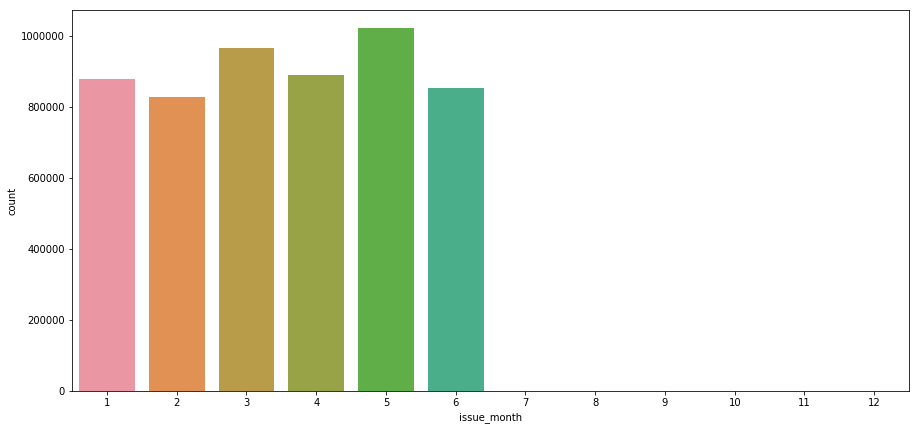

In [67]:
barPlotOnColumns('issue_month', 'count', ticketsFrequencyAcrossMonths.sort("issue_month").toPandas(), 'issue_month', (15,7))

#### As seen from the above graph, the number of tickets for the months from 7 to 12 are almost 0 as compared to the number of tickets issued for the months from 1 to 6.

### Let's create seasons out of these months based upon the information that
- <b>Fall Season - September, October, November
- Winter Season - December, January, February
- Spring Season - March, April, May
- Summer Season - June, July, August

In [69]:
#Let's create a udf for the transformation
def getSeasonFromMonth(month):
    if((month == 12) | (month == 1 or month == 2)):
        return "Winter Season"
    elif((month>=3) and (month<=5)):
        return "Spring Season"
    elif((month>=6) and (month<=8)):
        return "Summer Season"
    else:
        return "Fall Season"
getSeasonFromMonthUdf = udf(getSeasonFromMonth)

In [70]:
#checking if function is working correctly
for i in range(1,13):
    print(getSeasonFromMonth(i))

Winter Season
Winter Season
Spring Season
Spring Season
Spring Season
Summer Season
Summer Season
Summer Season
Fall Season
Fall Season
Fall Season
Winter Season


In [72]:
#Creating a new column i.e. 'issue_season'
data = data.withColumn("issue_season",getSeasonFromMonthUdf(col('issue_month')))
data.select("Issue Date", "issue_month","issue_season").show()

+----------+-----------+-------------+
|Issue Date|issue_month| issue_season|
+----------+-----------+-------------+
|2017-06-14|          6|Summer Season|
|2017-06-13|          6|Summer Season|
|2017-01-11|          1|Winter Season|
|2017-02-04|          2|Winter Season|
|2017-01-26|          1|Winter Season|
|2017-04-30|          4|Spring Season|
|2017-02-03|          2|Winter Season|
|2017-05-27|          5|Spring Season|
|2017-05-31|          5|Spring Season|
|2017-05-26|          5|Spring Season|
|2017-05-19|          5|Spring Season|
|2017-06-09|          6|Summer Season|
|2017-01-20|          1|Winter Season|
|2017-04-13|          4|Spring Season|
|2017-01-05|          1|Winter Season|
|2017-02-18|          2|Winter Season|
|2017-06-14|          6|Summer Season|
|2017-01-29|          1|Winter Season|
|2017-01-25|          1|Winter Season|
|2017-06-12|          6|Summer Season|
+----------+-----------+-------------+
only showing top 20 rows



### Let's find the frequencies of tickets for each season

In [73]:
frequenciesForEachSeason = data.groupBy("issue_season").count().sort('count', ascending = False)
frequenciesForEachSeason.show()

+-------------+-------+
| issue_season|  count|
+-------------+-------+
|Spring Season|2873320|
|Winter Season|1704662|
|Summer Season| 852849|
|  Fall Season|    979|
+-------------+-------+



#### Therefore, the most of the tickets are issued in the "Spring Season" followed by "Winter Season". The minimum number of tickets are issued in the "Fall Season"

#### Also, there is a vast difference between the "Spring Season" & the season with the second highest number of tickets i.e. "Winter Season". The difference is of more than 9.6 Lakhs tickets.

In [74]:
frequencyOnSeasonAndViolationCode = data.groupBy("issue_season","Violation Code").count()
frequencyOnSeasonAndViolationCode.cache()
frequencyOnSeasonAndViolationCode.show()

+-------------+--------------+------+
| issue_season|Violation Code| count|
+-------------+--------------+------+
|Winter Season|            49|   110|
|  Fall Season|            85|     3|
|Summer Season|            47| 10779|
|Spring Season|            55|    37|
|Summer Season|            60|   347|
|Summer Season|            97|    12|
|Spring Season|            87|     1|
|Summer Season|            46| 42666|
|Spring Season|            80|  1111|
|Summer Season|            55|     4|
|Spring Season|            40|147402|
|Winter Season|            92|     7|
|  Fall Season|            10|     3|
|Summer Season|            68|  4251|
|Winter Season|            76|     4|
|Summer Season|            15|     1|
|  Fall Season|            83|     2|
|Spring Season|            48| 21682|
|Winter Season|            32|     7|
|Summer Season|             0|    34|
+-------------+--------------+------+
only showing top 20 rows



In [75]:
w = Window.partitionBy('issue_season').orderBy(col('count').desc())
top3AmongEachSeason = frequencyOnSeasonAndViolationCode.withColumn('rank',dense_rank().over(w)).filter(col('rank')<4)
top3AmongEachSeason.show()

+-------------+--------------+------+----+
| issue_season|Violation Code| count|rank|
+-------------+--------------+------+----+
|  Fall Season|            46|   231|   1|
|  Fall Season|            21|   128|   2|
|  Fall Season|            40|   116|   3|
|Spring Season|            21|402399|   1|
|Spring Season|            36|344834|   2|
|Spring Season|            38|271167|   3|
|Summer Season|            21|127344|   1|
|Summer Season|            36| 96663|   2|
|Summer Season|            38| 83518|   3|
|Winter Season|            21|238179|   1|
|Winter Season|            36|221268|   2|
|Winter Season|            38|187385|   3|
+-------------+--------------+------+----+



<b>As we see above, the top 3 violation codes among each season in the descending order of number of tickets issued agains each of the violatino code are as follows:
- Fall Season -> 46, 21, 40
- Spring Season -> 21, 36, 38
- Summer Season -> 21, 36, 38
- Winter Season -> 21, 36, 38


### Let's calculate revenue for the police department

In [76]:
# Let's check frequency of top three violation codes
topThreeViolationCodes = data.groupBy('Violation Code').count().sort('count', ascending = False).limit(3)
topThreeViolationCodes.show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            21|768050|
|            36|662765|
|            38|542078|
+--------------+------+



In [77]:
# Let's calculate the total count of tickets generated against top three violation codes
data.groupBy('Violation Code').count().sort('count', ascending = False).limit(3).groupBy().sum().show()

+----------+
|sum(count)|
+----------+
|   1972893|
+----------+



<b> The information from the NYC Finance website for the top 3 violation codes is as follows:
- 21 => Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device => Dollar 65 and Dollar 45
- 36 => Exceeding the posted speed limit in or near a designated school zone. => Dollar 50 and Dollar 50
- 38 => Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts. => Dollar 65 and Dollar 35

In [78]:
#Let's create a UDF to calculate the revenue
def calculateRevenue(violationCode):
    if(violationCode == '21'):
        return ((65 + 45.0)/2)
    elif(violationCode == '36'):
        return ((50 + 50.0)/2)
    elif(violationCode == '38'):
        return ((65 + 35.0)/2)
calculateRevenueUdf = udf(calculateRevenue)

In [79]:
# Let's add a new column i.e. revenue & calculate the revenue generated for top 3 violation codes
topThreeViolationCodes.withColumn("revenue",calculateRevenueUdf(col("Violation Code")) * col("count")).sort('revenue',ascending = False).show()

+--------------+------+----------+
|Violation Code| count|   revenue|
+--------------+------+----------+
|            21|768050|4.224275E7|
|            36|662765|3.313825E7|
|            38|542078| 2.71039E7|
+--------------+------+----------+



### The violation code that has the highest total revenue is the violation code 21

In [80]:
# Let's calculate the total amount collected for the top 3 most occuring violation codes
topThreeViolationCodes.withColumn("revenue",calculateRevenueUdf(col("Violation Code")) * col("count")).sort('revenue',ascending = False).groupBy().sum().show()

+----------+------------+
|sum(count)|sum(revenue)|
+----------+------------+
|   1972893|  1.024849E8|
+----------+------------+



In [81]:
#Calculating total revenue in non-exponential format
1.024849*(10**8)

102484899.99999999

### Therefore, the total amount collected is $10,24,84,899.99


In [82]:
# Calculating revenue per ticket for the top 3 violation codes
(1.024849*(10**8)) / 1972893

51.946506982385756

### Therefore, the average revenue per ticket for the top 3 violation codes comes out to be $51.94

### From the above revenue calculations, it seems that the revenue just for the top 3 tickets is really very high.